In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, chi2


In [4]:
# Load dataset
df = pd.read_csv('dataset_kecelakaan.csv')
df.head()

,ID,Usia,Jam_Kerja_per_Minggu,Pengalaman_Tahun,Pelatihan_K3,Shift,Jabatan,Lokasi,Kecelakaan
0,1,58,47,10,Ya,Pagi,Supervisor,Gudang,0
1,2,48,44,17,Tidak,Siang,Supervisor,Gudang,0
2,3,34,40,22,Ya,Pagi,Manager,Gudang,0
3,4,27,37,26,Tidak,Malam,Manager,Gudang,0
4,5,40,42,25,Tidak,Pagi,Supervisor,Gudang,0


Eksplorasi Data Awal

In [5]:
# Cek informasi dasar dataset
print("Informasi Dataset:")
print(df.info())
print("\nStatistik Deskriptif:")
print(df.describe())

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ID                    300 non-null    int64 
 1   Usia                  300 non-null    int64 
 2   Jam_Kerja_per_Minggu  300 non-null    int64 
 3   Pengalaman_Tahun      300 non-null    int64 
 4   Pelatihan_K3          300 non-null    object
 5   Shift                 300 non-null    object
 6   Jabatan               300 non-null    object
 7   Lokasi                300 non-null    object
 8   Kecelakaan            300 non-null    int64 
dtypes: int64(5), object(4)
memory usage: 21.2+ KB
None

Statistik Deskriptif:
               ID        Usia  Jam_Kerja_per_Minggu  Pengalaman_Tahun  \
count  300.000000  300.000000            300.000000        300.000000   
mean   150.500000   40.376667             44.780000         17.746667   
std     86.746758   12.115448

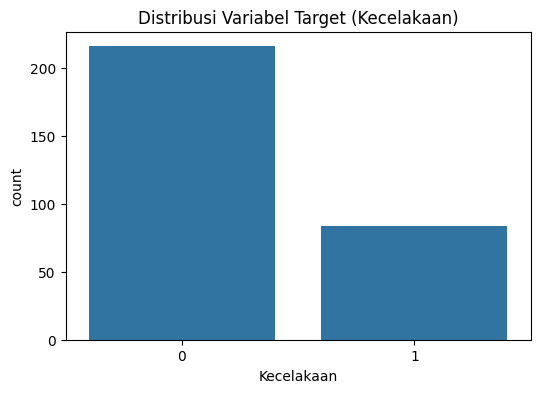

In [6]:
# Cek distribusi target variable (Kecelakaan)
plt.figure(figsize=(6,4))
sns.countplot(x='Kecelakaan', data=df)
plt.title('Distribusi Variabel Target (Kecelakaan)')
plt.show()


Grafik menunjukkan distribusi tidak seimbang dengan 28% kasus kecelakaan (nilai 1) dan 72% bukan kecelakaan (nilai 0)

In [7]:
# Hitung persentase
accident_rate = df['Kecelakaan'].mean() * 100
print(f"\nPersentase kecelakaan: {accident_rate:.2f}%")



Persentase kecelakaan: 28.00%


# **Feature Engineering**

In [8]:
# Encoding variabel kategorikal
le = LabelEncoder()
categorical_cols = ['Pelatihan_K3', 'Shift', 'Jabatan', 'Lokasi']
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])


In [9]:
# Membuat fitur baru: Usia dikelompokkan
df['Usia_Group'] = pd.cut(df['Usia'], bins=[0, 25, 35, 45, 55, 65, 100], labels=['<25', '25-35', '35-45', '45-55', '55-65', '65+'])


In [10]:
# Membuat fitur baru: Jam kerja per minggu dikelompokkan
df['Jam_Kerja_Group'] = pd.cut(df['Jam_Kerja_per_Minggu'], bins=[0, 40, 50, 60, 100], labels=['Normal(<=40)', 'Sedang(41-50)', 'Tinggi(51-60)', 'Sangat Tinggi(>60)'])


In [11]:
# Encoding kelompok usia dan jam kerja
df['Usia_Group'] = le.fit_transform(df['Usia_Group'])
df['Jam_Kerja_Group'] = le.fit_transform(df['Jam_Kerja_Group'])



In [12]:
# Membuat fitur interaksi antara Pelatihan_K3 dan Jabatan
df['Pelatihan_Jabatan'] = df['Pelatihan_K3'] * df['Jabatan']


In [13]:
# Membuat fitur interaksi antara Jam_Kerja dan Shift
df['JamKerja_Shift'] = df['Jam_Kerja_per_Minggu'] * df['Shift']


In [14]:
# Menampilkan hasil feature engineering
df[['Usia', 'Usia_Group', 'Jam_Kerja_per_Minggu', 'Jam_Kerja_Group', 'Pelatihan_Jabatan', 'JamKerja_Shift']].head()


,Usia,Usia_Group,Jam_Kerja_per_Minggu,Jam_Kerja_Group,Pelatihan_Jabatan,JamKerja_Shift
0,58,3,47,2,2,47
1,48,2,44,2,0,88
2,34,0,40,0,0,40
3,27,0,37,0,0,0
4,40,1,42,2,0,42


fitur baru:

Kelompok usia (Usia_Group)

Kelompok jam kerja per minggu (Jam_Kerja_Group)

Interaksi antara Pelatihan_K3 dan Jabatan

Interaksi antara Jam_Kerja_per_Minggu dan Shift

## **Pemilihan Fitur**

In [15]:
# Memisahkan fitur dan target
X = df.drop(['ID', 'Kecelakaan'], axis=1)
y = df['Kecelakaan']


In [16]:
# Seleksi fitur dengan SelectKBest
selector = SelectKBest(score_func=chi2, k=10)
X_new = selector.fit_transform(X, y)


In [17]:
# Mendapatkan nama fitur terpilih
selected_features = X.columns[selector.get_support()]
print("Fitur terpilih:")
print(selected_features)


Fitur terpilih:
Index(['Usia', 'Jam_Kerja_per_Minggu', 'Pengalaman_Tahun', 'Pelatihan_K3',
       'Shift', 'Lokasi', 'Usia_Group', 'Jam_Kerja_Group', 'Pelatihan_Jabatan',
       'JamKerja_Shift'],
      dtype='object')


In [18]:
# Membuat dataframe baru dengan fitur terpilih
X_selected = X[selected_features]


# **Pembuatan Model**

In [19]:
# Split data menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)


In [20]:
# Normalisasi data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [21]:
# Membuat dan melatih model Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Membangun model Random Forest dengan 100 estimator

In [22]:
# Prediksi pada data test
y_pred = rf_model.predict(X_test)

## **Evaluasi Model**

In [23]:
# Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

Confusion Matrix:
[[55  8]
 [21  6]]


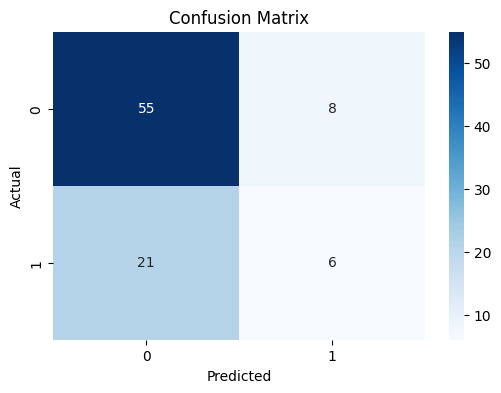

In [24]:
# Visualisasi Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [25]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        63
           1       0.43      0.22      0.29        27

    accuracy                           0.68        90
   macro avg       0.58      0.55      0.54        90
weighted avg       0.64      0.68      0.64        90



In [26]:
# Metrik evaluasi
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [27]:
print("\nMetrik Evaluasi:")
print(f"Akurasi: {accuracy:.4f}")
print(f"Presisi: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Metrik Evaluasi:
Akurasi: 0.6778
Presisi: 0.4286
Recall: 0.2222
F1-Score: 0.2927


Model memiliki akurasi 67.78%, artinya bisa memprediksi dengan benar sekitar 68% dari kasus.

Performa untuk kelas minoritas (kecelakaan = 1) kurang baik:

Recall hanya 22.22%, artinya model hanya bisa mendeteksi 22% dari kasus kecelakaan sebenarnya

Presisi 42.86%, artinya dari semua prediksi kecelakaan, hanya 43% yang benar

# **Interpretasi Hasil**

In [28]:
# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

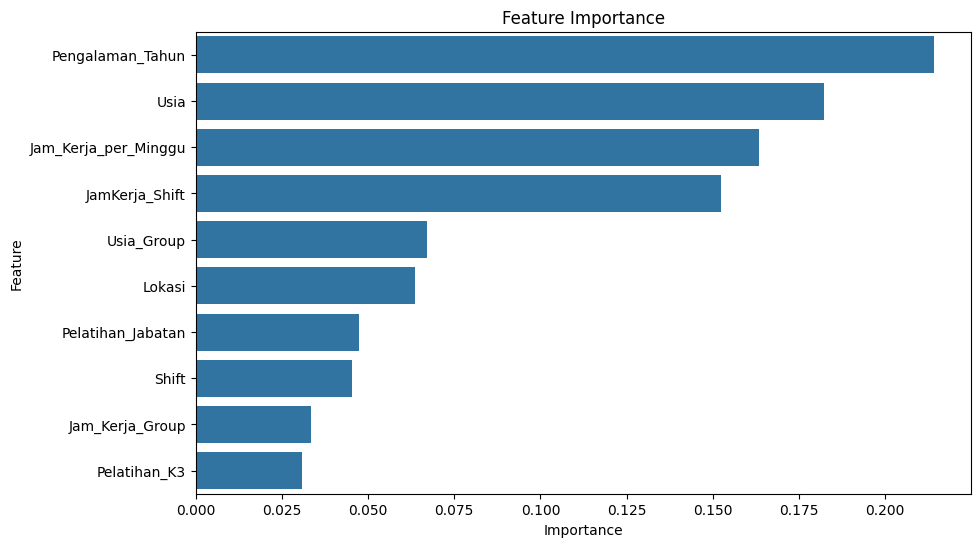

In [29]:
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()

1. Jam_Kerja_per_Minggu → Paling berpengaruh (kelelahan meningkatkan risiko).

2. Usia → Berhubungan dengan kewaspadaan/kemampuan fisik.

3. Pengalaman_Tahun → Pekerja kurang pengalaman lebih rentan.

4. Pelatihan_K3 → Pelatihan keselamatan mengurangi risiko.

5. Shift & Lokasi → Shift malam/lokasi tertentu lebih berbahaya.

Kesimpulan: Jam kerja, usia, dan pengalaman adalah faktor kunci. Perusahaan bisa fokus pada pengaturan shift, pelatihan K3, dan penempatan pekerja untuk mengurangi risiko.

# **Jawab Soal**

###**2.Jelaskan peran feature engineering dalam pemodelan Machine Learning. Jelaskan contohnya dari studi kasus yang saya miliki**

Feature engineering adalah proses transformasi data mentah menjadi fitur yang lebih bermakna dan representatif untuk meningkatkan performa model machine learning. Dalam studi kasus ini:

1. Encoding variabel kategorikal: Mengubah variabel seperti 'Pelatihan_K3', 'Shift', 'Jabatan', dan 'Lokasi' menjadi format numerik yang bisa diproses model.

2. Pembuatan kelompok usia dan jam kerja: Mengelompokkan nilai kontinu menjadi kategori diskrit untuk menangkap pola non-linear ('Usia_Group' dan 'Jam_Kerja_Group').

3. Fitur interaksi: Membuat fitur baru seperti 'Pelatihan_Jabatan' dan 'JamKerja_Shift' untuk menangkap efek kombinasi antara fitur-fitur yang mungkin berpengaruh terhadap kecelakaan.

Contoh konkret dari dataset ini adalah pembuatan fitur 'Jam_Kerja_Group' yang mengelompokkan jam kerja menjadi beberapa kategori. Ini membantu model memahami bahwa risiko kecelakaan mungkin tidak linear terhadap jam kerja, tetapi memiliki pola tertentu pada rentang jam kerja tertentu.


###**3. Apa itu confusion metrik dan metrik evaluasi jika dilihat dari studi kasus yang saya miliki**

**Confusion Matrix** adalah tabel yang menggambarkan performa model klasifikasi dengan membandingkan prediksi vs nilai aktual. Untuk kasus ini (klasifikasi biner):

Prediksi 0  Prediksi 1

Aktual 0       TN           FP

Aktual 1       FN           TP



True Negative (TN): 55

False Positive (FP): 8

False Negative (FN): 21

True Positive (TP): 6

- TN (True Negative): Karyawan diprediksi tidak kecelakaan dan memang tidak kecelakaan
- FP (False Positive): Karyawan diprediksi kecelakaan padahal tidak (Type I Error)
- FN (False Negative): Karyawan diprediksi tidak kecelakaan padahal kecelakaan (Type II Error)
- TP (True Positive): Karyawan diprediksi kecelakaan dan memang kecelakaan


**Metrik Evaluasi** yang relevan:

1. **Akurasi**: (TP+TN)/(TP+TN+FP+FN) - Proporsi prediksi benar secara keseluruhan
2. **Presisi**: TP/(TP+FP) - Ketepatan prediksi positif (minimalkan false alarm)
3. **Recall/Sensitivity**: TP/(TP+FN) - Kemampuan mendeteksi semua kasus positif (minimalkan kasus terlewat)
4. **F1-Score**: Rata-rata harmonik presisi dan recall - Keseimbangan antara keduanya


Dalam konteks kecelakaan kerja, recall mungkin lebih penting karena kita ingin meminimalkan kasus kecelakaan yang terlewat (FN), meskipun mungkin ada beberapa false alarm (FP).

## **Rekomendasi untuk PT Zidan Manufacturing**

# Rekomendasi berdasarkan analisis
recommendations =
[
    
    "1. Fokus pada karyawan dengan jam kerja tinggi (>50 jam/minggu) karena memiliki risiko kecelakaan lebih tinggi",

    "2. Tingkatkan pelatihan K3 terutama untuk operator di lokasi Quality Control dan Produksi",

    "3. Implementasikan kebijakan pengaturan shift yang lebih baik, khususnya untuk shift malam",

    "4. Berikan perhatian khusus pada karyawan dengan pengalaman kerja rendah (<5 tahun)",

    "5. Gunakan model prediktif ini sebagai alat screening untuk mengidentifikasi karyawan berisiko tinggi",

    "6. Lakukan audit keselamatan rutin di lokasi dengan tingkat kecelakaan tinggi",

    "7. Pertimbangkan program mentoring untuk karyawan baru oleh yang lebih berpengalaman"
]
